**14장 – 합성곱 신경망을 사용한 컴퓨터 비전**

_이 노트북은 14장에 있는 모든 샘플 코드와 연습문제 해답을 가지고 있습니다._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/handson-ml2/blob/master/14_deep_computer_vision_with_cnns.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지와 텐서플로 버전이 2.0 이상인지 확인합니다.

In [12]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 코랩에서 실행되는 노트북인가요?
IS_COLAB = "google.colab" in sys.modules

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 CNN은 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")

# 골통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

흑백 이미지와 컬러 이미지 출력을 위한 유틸리티 함수:

In [13]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

# 합성곱이란 무엇인가?

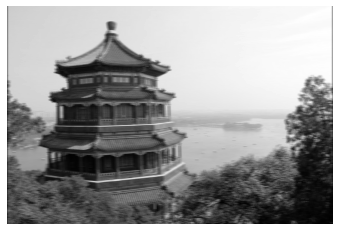

In [14]:
import numpy as np
from sklearn.datasets import load_sample_image

# 샘플 이미지를 로드합니다.
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# 2개의 필터를 만듭니다.
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # 수직선
filters[3, :, :, 1] = 1  # 수평선

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # 첫 번째 이미지의 두 번째 특성맵을 그립니다.
plt.axis("off") # 책에는 없습니다.
plt.show()

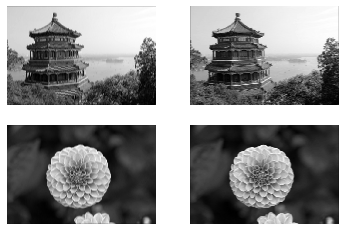

In [15]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

In [16]:
def crop(images):
    return images[150:220, 130:250]

그림 저장 china_original


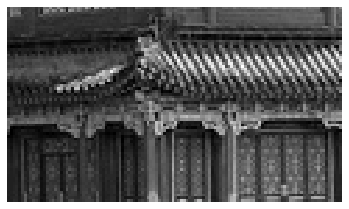

그림 저장 china_vertical


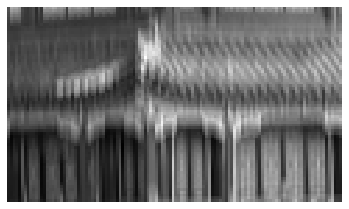

그림 저장 china_horizontal


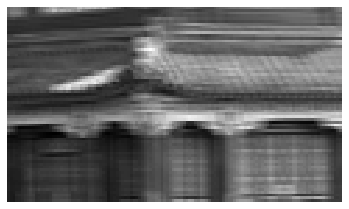

In [17]:
plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

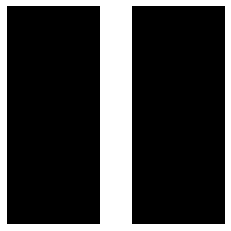

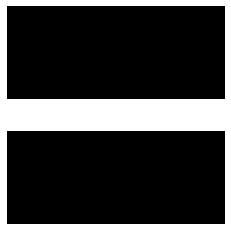

In [18]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

## 합성곱 층

`keras.layers.Conv2D()`를 사용해 2D 합성곱 층을 만들어 보죠:

In [19]:
np.random.seed(42)
tf.random.set_seed(42)

conv = keras.layers.Conv2D(filters=2, kernel_size=7, strides=1,
                           padding="SAME", activation="relu", input_shape=outputs.shape)

두 개의 테스트 이미지로 이 층을 호출합니다:

In [20]:
conv_outputs = conv(images)
conv_outputs.shape 

TensorShape([2, 427, 640, 2])

출력은 4D 텐서입니다. 차원은 배치 크기, 높이, 너비, 채널입니다. 2개의 이미지를 입력으로 사용했기 때문에 첫 번째 차원(배치 크기)는 2입니다. 다음 두 차원은 출력 특성맵의 높이와 너비입니다. `padding="SAME"`와 `strides=1`로 설정했기 때문에 출력 특성맵의 높이와 너비는 입력 이미지와 같습니다(이 경우 427×640). 마지막으로 이 합성곱 층은 2개의 필터를 사용합니다. 따라서 마지막 차원의 크기는 2입니다. 즉 입력 이미지마다 2개의 특성맵이 출력됩니다.

필터는 초기에 랜덤하게 초기화되기 때문에 처음에는 랜덤한 패턴을 감지합니다. 이미지마다 출력된 2개의 특성맵을 확이해 보죠:

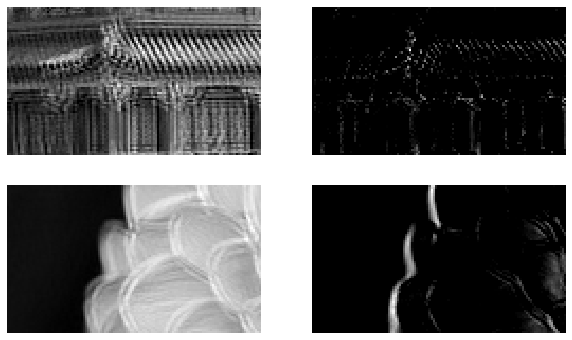

In [21]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

필터가 초기에 랜덤하게 초기화되엇지만 두 번째 필터는 에지를 감지한 것처럼 보입니다. 랜덤하게 초기화된 필터는 종종 이런 식으로 동작합니다. 에지 감지는 이미지 처리에 매우 유용하기 때문에 운이 좋습니다.

원한다면 필터를 앞에서 수동으로 정의한 필터를 사용하고 편향을 0으로 지정할 수 있습니다(합성곱 층이 훈련하는 동안 적절한 필터와 편향을 학습하기 때문에 실제로는 수동으로 필터와 편향을 지정할 필요가 거의 없습니다):

In [22]:
conv.set_weights([filters, np.zeros(2)])

이제 이 층을 동일한 두 이미지에서 다시 호출해 보죠. 그다음 출력 특성맵이 (앞에서처럼) 수직선과 수평선을 부각하는지 확인해 보겠습니다:

In [23]:
conv_outputs = conv(images)
conv_outputs.shape 

TensorShape([2, 427, 640, 2])

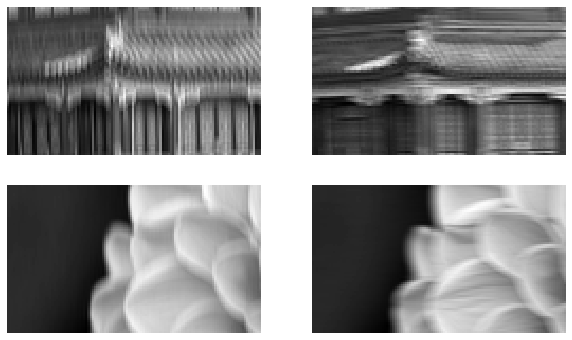

In [24]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

## VALID vs SAME 패딩

In [25]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1

In [26]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

In [27]:
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images

`"SAME"` 패딩을 사용하는 것은 `manual_same_padding()`을 사용해 수동으로 패딩하고 `"VALID"` 패딩을 사용하는 것과 동일합니다(혼동될 수 있지만 `"VALID"` 패딩은 전혀 패딩을 하지 않는다는 뜻입니다):

In [28]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# conv_same의 가중치를 생성하기 위해 build() 메서드를 호출해야 합니다.
conv_same.build(tf.TensorShape(images.shape))

# conv_valid의 가중치를 conv_same으로 복사합니다.
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())

# 풀링 층

## 최대 풀링

In [29]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [30]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

그림 저장 china_max_pooling


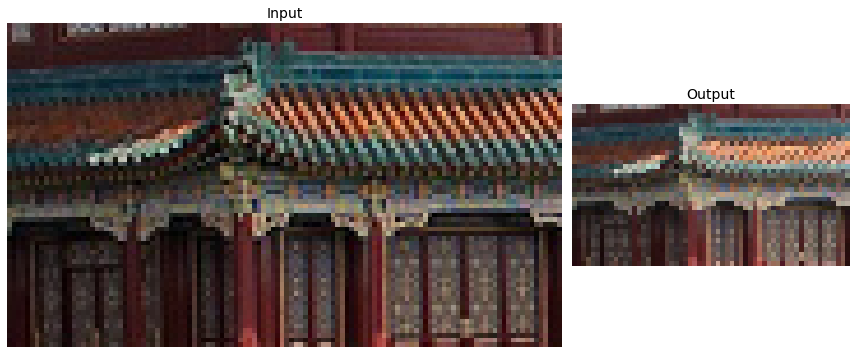

In [31]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # 첫 번째 이미지 그리기
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # 첫 번째 이미지 출력 그리기
ax2.axis("off")
save_fig("china_max_pooling")
plt.show()

## 깊이 방향(depth-wise) 풀링

In [32]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)

In [33]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"): # 아직 GPU 커널이 없습니다.
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

또는 `Lambda` 층을 사용합니다:

In [34]:
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))
with tf.device("/cpu:0"): # 아직 GPU 커널이 없습니다.
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

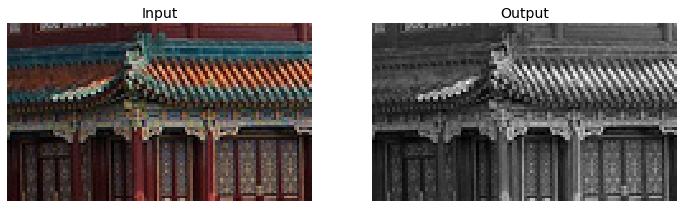

In [35]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # 첫 번째 이미지 그리기
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # 첫 번째 이미지 출력 그리기
plt.axis("off")
plt.show()

## 평균 풀링

In [36]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [37]:
output_avg = avg_pool(cropped_images)

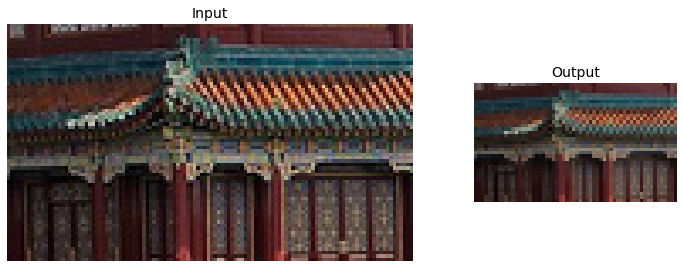

In [38]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # 첫 번째 이미지 그리기
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # 첫 번째 이미지 출력 그리기
ax2.axis("off")
plt.show()

## 전역 평균 풀링

In [39]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45951638, 0.33423486]], dtype=float32)>

In [40]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45951638, 0.33423486]], dtype=float32)>

# CNN으로 패션 MNIST 문제 풀기

In [41]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

4423680/4422102 [==============================] - 0s 0us/step


In [42]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [43]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # 새로운 이미지처럼 사용합니다
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 39s 21ms/step - loss: 0.7084 - accuracy: 0.7519 - val_loss: 0.3652 - val_accuracy: 0.8698
Epoch 2/10
1719/1719 [==============================] - 36s 21ms/step - loss: 0.4225 - accuracy: 0.8588 - val_loss: 0.3589 - val_accuracy: 0.8812
Epoch 3/10
1719/1719 [==============================] - 36s 21ms/step - loss: 0.3691 - accuracy: 0.8751 - val_loss: 0.3151 - val_accuracy: 0.8890
Epoch 4/10
1719/1719 [==============================] - 36s 21ms/step - loss: 0.3317 - accuracy: 0.8871 - val_loss: 0.2793 - val_accuracy: 0.8958
Epoch 5/10
1719/1719 [==============================] - 36s 21ms/step - loss: 0.3079 - accuracy: 0.8956 - val_loss: 0.2957 - val_accuracy: 0.8962
Epoch 6/10
1719/1719 [==============================] - 35s 20ms/step - loss: 0.2891 - accuracy: 0.9023 - val_loss: 0.2730 - val_accuracy: 0.8990
Epoch 7/10
1719/1719 [==============================] - 35s 20ms/step - loss: 0.2771 - accuracy: 0.9050 - val_loss: 0.2911 -

## ResNet-34

In [44]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        # 아래는 잔차 경로
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        # 아래는 숏컷
        self.skip_layers = []
        # 만약 스트라이드가 2라면 파선 경로이다.
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        # 여기서 포인트는 for문이 돌아가면서 Z 값이 업뎃된다는 것이다!
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
            print(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [45]:
# 여기서 포인트는 for문이 돌아가면서 Z 값이 업뎃된다는 것이다!

main_layers = [3,5,7]

def call(inputs):
    Z = inputs
    for layer in main_layers:
        Z = layer*inputs
        print(Z)

call(3)

9
15
21


In [46]:
model = keras.models.Sequential()
# 1층
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
# 2층
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))

# 잔차 블록 시작!
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    # 특성 맵의 수가 2배가 되는 지점에선 스트라이드도 2배로 늘려준다.
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

Tensor("residual_unit/conv2d_9/Conv2D:0", shape=(None, 56, 56, 64), dtype=float32)
Tensor("residual_unit/batch_normalization_1/FusedBatchNormV3:0", shape=(None, 56, 56, 64), dtype=float32)
Tensor("residual_unit/Relu:0", shape=(None, 56, 56, 64), dtype=float32)
Tensor("residual_unit/conv2d_10/Conv2D:0", shape=(None, 56, 56, 64), dtype=float32)
Tensor("residual_unit/batch_normalization_2/FusedBatchNormV3:0", shape=(None, 56, 56, 64), dtype=float32)
Tensor("residual_unit_1/conv2d_11/Conv2D:0", shape=(None, 56, 56, 64), dtype=float32)
Tensor("residual_unit_1/batch_normalization_3/FusedBatchNormV3:0", shape=(None, 56, 56, 64), dtype=float32)
Tensor("residual_unit_1/Relu:0", shape=(None, 56, 56, 64), dtype=float32)
Tensor("residual_unit_1/conv2d_12/Conv2D:0", shape=(None, 56, 56, 64), dtype=float32)
Tensor("residual_unit_1/batch_normalization_4/FusedBatchNormV3:0", shape=(None, 56, 56, 64), dtype=float32)
Tensor("residual_unit_2/conv2d_13/Conv2D:0", shape=(None, 56, 56, 64), dtype=float32)
T

In [47]:
[64] * 3 + [128] * 4 + [256] * 6 + [512] * 3

[64, 64, 64, 128, 128, 128, 128, 256, 256, 256, 256, 256, 256, 512, 512, 512]

In [48]:
'첫 번째 층 파라미터 수', (7*7*3)*64, '두 번째 배치 정규화 층 파라미터 수', 64*4

('첫 번째 층 파라미터 수', 9408, '두 번째 배치 정규화 층 파라미터 수', 256)

In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)       

## 사전 훈련된 모델 사용하기

In [90]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

In [51]:
[name for name in dir(keras.applications)]

['DenseNet121',
 'DenseNet169',
 'DenseNet201',
 'EfficientNetB0',
 'EfficientNetB1',
 'EfficientNetB2',
 'EfficientNetB3',
 'EfficientNetB4',
 'EfficientNetB5',
 'EfficientNetB6',
 'EfficientNetB7',
 'InceptionResNetV2',
 'InceptionV3',
 'MobileNet',
 'MobileNetV2',
 'MobileNetV3Large',
 'MobileNetV3Small',
 'NASNetLarge',
 'NASNetMobile',
 'ResNet101',
 'ResNet101V2',
 'ResNet152',
 'ResNet152V2',
 'ResNet50',
 'ResNet50V2',
 'VGG16',
 'VGG19',
 'Xception',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys',
 'densenet',
 'efficientnet',
 'imagenet_utils',
 'inception_resnet_v2',
 'inception_v3',
 'mobilenet',
 'mobilenet_v2',
 'mobilenet_v3',
 'nasnet',
 'resnet',
 'resnet50',
 'resnet_v2',
 'vgg16',
 'vgg19',
 'xception']

(2, 224, 224, 3)


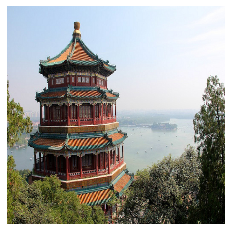

In [78]:
images_resized = tf.image.resize(images, [224, 224])
print(images_resized.shape) # 차이나랑 플라워 중에 0번째는 차이나!
plot_color_image(images_resized[0])
plt.show()

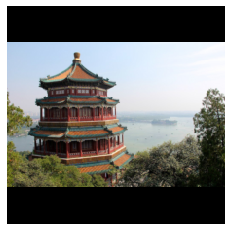

In [79]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

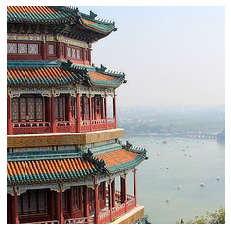

In [80]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

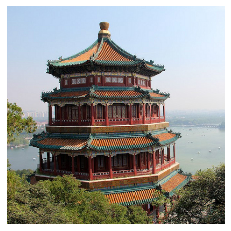

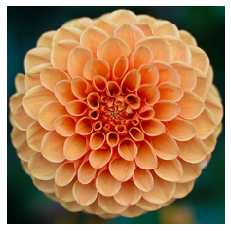

In [84]:
# box 들을 잘 모르겠군...
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

In [91]:
print(images.min(), images.max())
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

0.0 1.0


In [92]:
Y_proba.shape
# 2행은 중국과 플라워 데이터 2개이고 행은 1000개의 클래스로 분류될 확률들이다.

(2, 1000)

In [101]:
Y_proba[0,:].sum()

1.0

In [58]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)): # 첫 차원만 len이 인식한다.
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

40960/35363 [==================================] - 0s 0us/step
Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.07%
  n03781244 - monastery    11.70%

Image #1
  n04522168 - vase         53.96%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.97%



In [102]:
range(len(images))

range(0, 2)

## 전이 학습을 위한 사전 훈련된 모델

In [104]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

In [108]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.1,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

In [107]:
info.splits

{'train': <tfds.core.SplitInfo num_examples=3670>}

In [61]:
info.splits["train"]

<tfds.core.SplitInfo num_examples=3670>

In [62]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [63]:
n_classes = info.features["label"].num_classes

In [109]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

**경고:** TFDS의 split API는 책이 출간된 후에 바뀌었습니다. [새로운 split API](https://www.tensorflow.org/datasets/splits)(S3 슬라이싱 API)는 사용하기 훨씬 간단합니다:

In [65]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

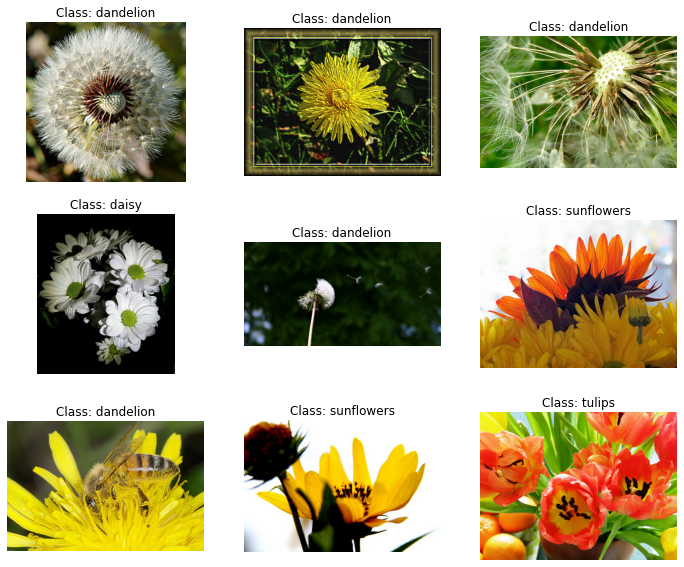

In [66]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

기본 전처리:

In [110]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

조금 더 정교한 전처리 (하지만 훨씬 많은 데이터 증식을 할 수 있습니다):

In [117]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

# 32개씩 묶는다.
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

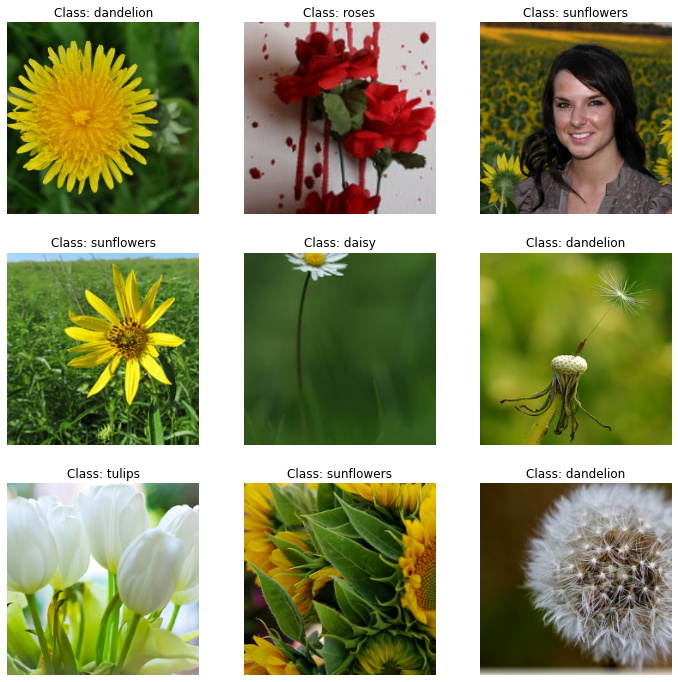

In [118]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

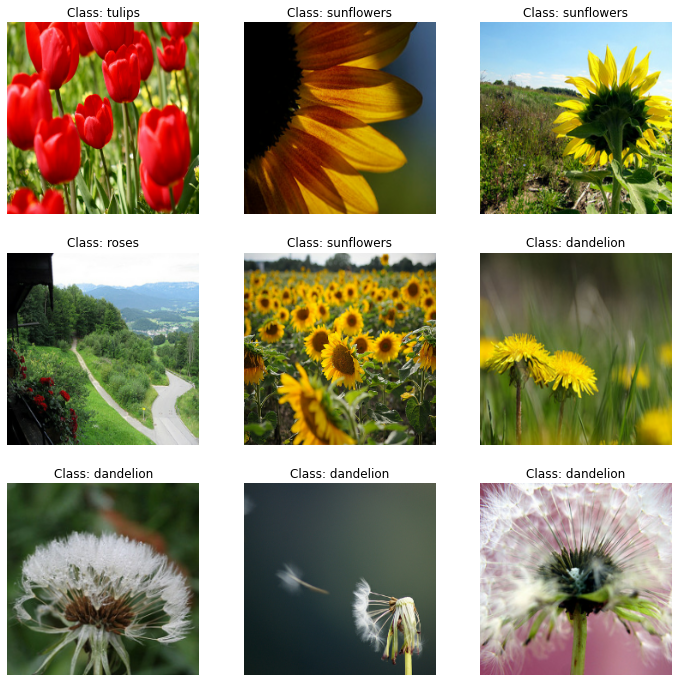

In [119]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [120]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [121]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_6
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_48
13 block2_pool
14 batch_normalization_40
15 add_12
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_49
23 block3_pool
24 batch_normalization_41
25 add_13
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_50
33 block4_pool
34 batch_normalization_42
35 add_14
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_15
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 blo

In [73]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
# decay : 0보다 크거나 같은 float 값. 업데이트마다 적용되는 학습률의 감소율입니다.
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


86/86 [==============================] - 37s 366ms/step - loss: 1.4720 - accuracy: 0.7925 - val_loss: 1.4752 - val_accuracy: 0.8070
Epoch 2/5
86/86 [==============================] - 30s 355ms/step - loss: 0.6576 - accuracy: 0.8914 - val_loss: 0.9815 - val_accuracy: 0.8732
Epoch 3/5
86/86 [==============================] - 30s 354ms/step - loss: 0.3623 - accuracy: 0.9248 - val_loss: 0.8554 - val_accuracy: 0.8732
Epoch 4/5
86/86 [==============================] - 30s 354ms/step - loss: 0.2582 - accuracy: 0.9335 - val_loss: 0.7072 - val_accuracy: 0.8842
Epoch 5/5
86/86 [==============================] - 30s 354ms/step - loss: 0.2029 - accuracy: 0.9440 - val_loss: 0.7266 - val_accuracy: 0.8732


In [123]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40) # 원래 40인데...넘 오래 걸려서 5번만 했다.

Epoch 1/5
86/86 [==============================] - 122s 1s/step - loss: 0.0694 - accuracy: 0.9760 - val_loss: 0.1989 - val_accuracy: 0.9393
Epoch 2/5
86/86 [==============================] - 117s 1s/step - loss: 0.0515 - accuracy: 0.9840 - val_loss: 0.2192 - val_accuracy: 0.9191
Epoch 3/5
86/86 [==============================] - 117s 1s/step - loss: 0.0325 - accuracy: 0.9916 - val_loss: 0.1948 - val_accuracy: 0.9283
Epoch 4/5
86/86 [==============================] - 117s 1s/step - loss: 0.0255 - accuracy: 0.9924 - val_loss: 0.2090 - val_accuracy: 0.9357
Epoch 5/5
86/86 [==============================] - 117s 1s/step - loss: 0.0301 - accuracy: 0.9920 - val_loss: 0.2407 - val_accuracy: 0.9210


In [148]:
history.history
# 에폭마다 값들이 나온다.

{'accuracy': [0.976017415523529,
  0.9840116500854492,
  0.991642415523529,
  0.9923691749572754,
  0.9920058250427246],
 'loss': [0.06936446577310562,
  0.05153779685497284,
  0.03245530650019646,
  0.025502119213342667,
  0.03011045977473259],
 'val_accuracy': [0.939338207244873,
  0.9191176295280457,
  0.9283088445663452,
  0.935661792755127,
  0.9209558963775635],
 'val_loss': [0.19890469312667847,
  0.2191862165927887,
  0.19482649862766266,
  0.20903579890727997,
  0.24069344997406006]}

In [149]:
results = model.evaluate(test_set, batch_size=32) # 32배치로 묶인 게 12묶음 이다.

12/12 [==============================] - 5s 376ms/step - loss: 0.1848 - accuracy: 0.9455


In [151]:
print("test loss, test acc:", results)

test loss, test acc: [0.18483230471611023, 0.9455040693283081]


In [146]:
for X_batch, y_batch in test_set:
  print(X_batch.shape)

(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(15, 224, 224, 3)


In [201]:
preds = model.predict(test_set)

In [197]:
preds.shape

(367, 5)

In [204]:
pred_index = np.argmax(preds, axis=1)
pred_index

array([2, 3, 3, 2, 3, 0, 0, 0, 0, 1, 3, 2, 4, 1, 2, 1, 2, 4, 2, 2, 0, 0,
       0, 2, 0, 3, 0, 1, 1, 1, 2, 1, 0, 0, 1, 1, 0, 3, 0, 4, 0, 3, 0, 4,
       3, 3, 2, 4, 0, 1, 2, 1, 3, 0, 1, 4, 1, 0, 2, 3, 0, 0, 4, 0, 1, 1,
       0, 1, 2, 4, 3, 3, 0, 3, 4, 2, 1, 0, 3, 2, 0, 0, 4, 3, 0, 3, 3, 2,
       0, 2, 1, 4, 0, 3, 3, 3, 1, 4, 0, 4, 4, 4, 4, 0, 4, 2, 3, 4, 0, 0,
       4, 4, 4, 2, 2, 4, 2, 3, 3, 0, 3, 2, 0, 1, 2, 1, 4, 3, 0, 2, 0, 2,
       2, 4, 0, 3, 0, 0, 1, 2, 0, 1, 4, 3, 1, 2, 2, 0, 3, 3, 4, 0, 4, 0,
       4, 0, 4, 2, 0, 0, 2, 4, 0, 0, 0, 1, 1, 0, 4, 0, 4, 4, 3, 1, 0, 1,
       2, 3, 4, 0, 2, 3, 2, 4, 1, 0, 0, 4, 4, 2, 0, 3, 4, 0, 0, 2, 3, 2,
       0, 2, 2, 3, 4, 0, 1, 4, 1, 0, 1, 2, 1, 2, 2, 2, 1, 0, 4, 2, 4, 1,
       0, 0, 4, 2, 1, 0, 3, 2, 1, 4, 3, 1, 3, 0, 0, 2, 3, 4, 0, 1, 2, 4,
       0, 3, 1, 0, 1, 2, 4, 0, 4, 4, 2, 3, 0, 2, 1, 2, 2, 4, 1, 4, 4, 3,
       0, 0, 0, 2, 4, 0, 2, 2, 2, 2, 0, 3, 1, 4, 2, 3, 3, 3, 2, 0, 3, 3,
       4, 4, 4, 2, 2, 3, 3, 3, 0, 0, 2, 0, 4, 1, 0,

In [184]:
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [203]:
class_names[pred_index[0]]

'tulips'

In [192]:
for X_batch, y_batch in test_set:
  print(y_batch)
# 흐음 틀린 값을 알 순 없나?

tf.Tensor([2 3 3 4 3 0 0 0 0 1 3 2 4 1 2 1 2 4 2 2 0 0 0 2 0 3 0 1 1 1 2 1], shape=(32,), dtype=int64)
tf.Tensor([0 0 1 1 0 3 0 4 4 3 0 4 3 3 2 4 0 1 2 1 3 0 1 4 1 0 2 3 0 0 4 0], shape=(32,), dtype=int64)
tf.Tensor([1 1 0 1 2 4 3 3 0 3 2 2 1 0 3 2 0 0 4 3 0 3 3 2 0 2 1 4 0 3 3 3], shape=(32,), dtype=int64)
tf.Tensor([1 4 0 4 4 4 4 0 4 2 3 4 0 0 4 4 4 2 2 4 4 3 3 0 3 2 0 1 2 1 4 3], shape=(32,), dtype=int64)
tf.Tensor([0 2 0 2 2 4 0 3 0 0 1 2 0 1 2 3 1 2 2 0 3 3 4 0 4 0 4 0 2 2 1 0], shape=(32,), dtype=int64)
tf.Tensor([2 4 0 0 0 1 1 0 4 1 4 4 3 1 0 1 2 3 4 0 0 3 2 4 1 0 0 4 4 2 0 3], shape=(32,), dtype=int64)
tf.Tensor([4 0 0 1 3 2 0 2 2 3 4 0 1 4 1 0 1 2 1 2 2 2 1 0 4 2 4 1 0 0 4 2], shape=(32,), dtype=int64)
tf.Tensor([1 0 3 2 1 4 3 1 3 0 0 2 3 4 0 1 2 4 0 3 1 0 1 2 4 0 4 4 2 3 0 4], shape=(32,), dtype=int64)
tf.Tensor([1 2 2 4 2 2 3 3 0 0 0 2 4 0 2 2 2 2 0 3 1 4 2 3 3 3 2 0 3 3 4 4], shape=(32,), dtype=int64)
tf.Tensor([4 4 2 3 3 3 0 0 2 0 4 1 0 0 4 3 0 0 0 4 0 2 4 1 3 0 2 3 3 0 2 

# 분류와 위치 추정

In [205]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg) # 클래스도 나누고
loc_output = keras.layers.Dense(4)(avg) # 바운딩 박스를 위한 물체 중심의 수평, 수직 좌표와 높이, 너비
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], # 어떤 것을 중요하게 생각하느냐에 따라
              optimizer=optimizer, metrics=["accuracy"])

In [206]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

In [207]:
model.fit(fake_train_set, steps_per_epoch=5, epochs=2)

Epoch 1/2
5/5 [==============================] - 11s 1s/step - loss: 1.3150 - dense_6_loss: 1.5676 - dense_7_loss: 0.3048 - dense_6_accuracy: 0.3063 - dense_7_accuracy: 0.2937
Epoch 2/2
5/5 [==============================] - 7s 1s/step - loss: 1.2152 - dense_6_loss: 1.4678 - dense_7_loss: 0.2049 - dense_6_accuracy: 0.3812 - dense_7_accuracy: 0.2438


### mAP(Mean Average Precision)

In [208]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

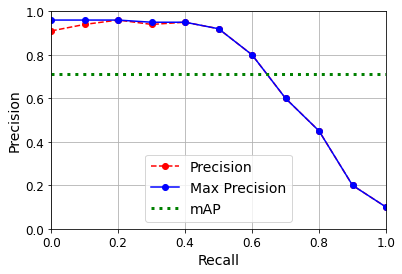

In [209]:
recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo-", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center", fontsize=14)
plt.show()

전치 합성곱:

In [210]:
tf.random.set_seed(42)
X = images_resized.numpy()

conv_transpose = keras.layers.Conv2DTranspose(filters=5, kernel_size=3, strides=2, padding="VALID")
output = conv_transpose(X)
output.shape

TensorShape([2, 449, 449, 5])

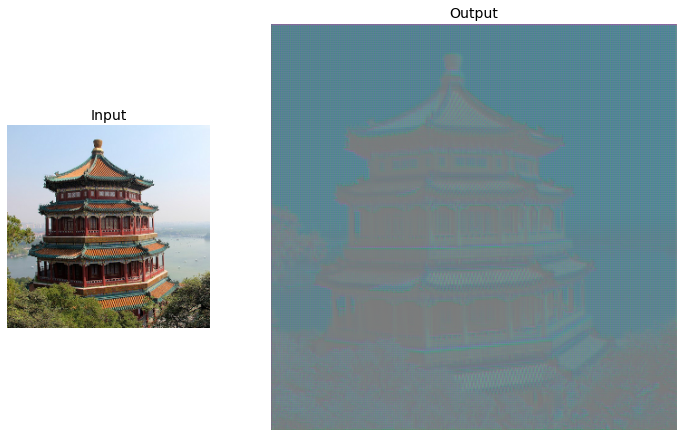

In [211]:
def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])  # 첫 번째 이미지 그리기
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(normalize(output[0, ..., :3]), interpolation="bicubic")  # 첫 번째 이미지 출력 그리기
ax2.axis("off")
plt.show()

In [ ]:
def upscale_images(images, stride, kernel_size):
    batch_size, height, width, channels = images.shape
    upscaled = np.zeros((batch_size,
                         (height - 1) * stride + 2 * kernel_size - 1,
                         (width - 1) * stride + 2 * kernel_size - 1,
                         channels))
    upscaled[:,
             kernel_size - 1:(height - 1) * stride + kernel_size:stride,
             kernel_size - 1:(width - 1) * stride + kernel_size:stride,
             :] = images
    return upscaled

In [ ]:
upscaled = upscale_images(X, stride=2, kernel_size=3)
weights, biases = conv_transpose.weights
reversed_filters = np.flip(weights.numpy(), axis=[0, 1])
reversed_filters = np.transpose(reversed_filters, [0, 1, 3, 2])
manual_output = tf.nn.conv2d(upscaled, reversed_filters, strides=1, padding="VALID")

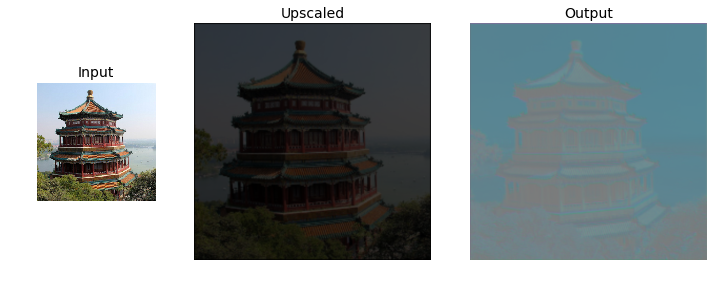

In [ ]:
def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[1, 2, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])  # 첫 번째 이미지 그리기
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Upscaled", fontsize=14)
ax2.imshow(upscaled[0], interpolation="bicubic")
ax2.axis("off")
ax3 = fig.add_subplot(gs[0, 2])
ax3.set_title("Output", fontsize=14)
ax3.imshow(normalize(manual_output[0, ..., :3]), interpolation="bicubic")  # 첫 번째 이미지 출력 그리기
ax3.axis("off")
plt.show()

In [ ]:
np.allclose(output, manual_output.numpy(), atol=1e-7)

True

# 연습문제

## 1. to 8.

부록 A 참조.

## 9. MNIST에서 높은 정확도를 내는 CNN 만들기
_연습문제: 자신만의 CNN을 만들고 MNIST 데이터셋에서 가능한 최대 정확도를 달성해보세요._

다음 모델은 2개의 합성곱 층과 1개의 풀링 층을 사용합니다. 그다음 25% 드롭아웃하고 이어서 밀집 층을 놓고 50% 드롭아웃을 다시 적용합니다. 마지막에 출력층을 놓습니다. 이 모델은 테스트 세트에서 약 99.2% 정확도를 냅니다. 이 모델은 [MNIST 캐글 경연대회](https://www.kaggle.com/c/digit-recognizer/)에서 상위 20위 안에 포함되는 수준입니다(Chris Deotte가 [이 포스트](https://www.kaggle.com/c/digit-recognizer/discussion/61480)에서 설명했듯이 테스트 세트에서 훈련된 것 같은 99.79%보다 높은 정확도를 가진 모델은 무시합니다). 더 높일 수 있을까요? 테스트 세트에서 99.5~99.7% 사이의 정확도를 달성하려면 이미지 증식, 배치 정규화를 추가하고 1-cycle 같은 학습률 스케줄을 사용하고 앙상블 모델을 만들어야 합니다.

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full / 255.
X_test = X_test / 255.
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
model.evaluate(X_test, y_test)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 102s 2ms/sample - loss: 0.1887 - accuracy: 0.9417 - val_loss: 0.0502 - val_accuracy: 0.9864
Epoch 2/10
55000/55000 [==============================] - 99s 2ms/sample - loss: 0.0815 - accuracy: 0.9754 - val_loss: 0.0414 - val_accuracy: 0.9904
Epoch 3/10
55000/55000 [==============================] - 103s 2ms/sample - loss: 0.0612 - accuracy: 0.9810 - val_loss: 0.0367 - val_accuracy: 0.9896
Epoch 4/10
55000/55000 [==============================] - 100s 2ms/sample - loss: 0.0496 - accuracy: 0.9846 - val_loss: 0.0376 - val_accuracy: 0.9900
Epoch 5/10
55000/55000 [==============================] - 104s 2ms/sample - loss: 0.0405 - accuracy: 0.9876 - val_loss: 0.0363 - val_accuracy: 0.9916
Epoch 6/10
55000/55000 [==============================] - 99s 2ms/sample - loss: 0.0368 - accuracy: 0.9882 - val_loss: 0.0352 - val_accuracy: 0.9924
Epoch 7/10
55000/55000 [=============================

[0.027682604857745575, 0.992]

## 10. 전이 학습을 사용한 대규모 이미지 분류

_연습문제: 다음 단계를 따라 전이 학습을 사용해 대규모 이미지 분류를 수행해보세요:_

* _클래스마다 최소한 100개의 이미지가 들어 있는 훈련 세트를 만드세요. 예를 들어 위
치에 따라(해변, 산, 도심 등) 자신의 사진을 분류하거나, 기존의 데이터셋(예를 들
면, 텐서플로 데이터셋)을 사용할 수도 있습니다._
* _이를 훈련 세트와 검증 세트, 테스트 세트로 나눕니다._
* _적절한 전처리 연산과 선택적으로 데이터 증식을 수행하는 입력 파이프라인을 만듭
니다._
* _이 데이터셋에서 사전훈련된 모델을 세부 튜닝합니다._

Flowers 예제를 참고하세요.

## 11.
_연습문제: 텐서플로의 [스타일 전이 튜토리얼](https://homl.info/styletuto)을 살펴보세요. 딥러
닝을 사용해 재미있는 그림을 생성할 수 있습니다._

코랩을 사용해 튜토리얼을 따라해 보세요.